# Regularization of Linear Regression Algorithm

This notebook illustrates how using regularization can prevent overfitting. A linear regression algorithm was used, and different values of the regularization parameter were tested to show the effect on the error rate.


In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
font = {'size': 16}
matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = [8, 6]

# Data

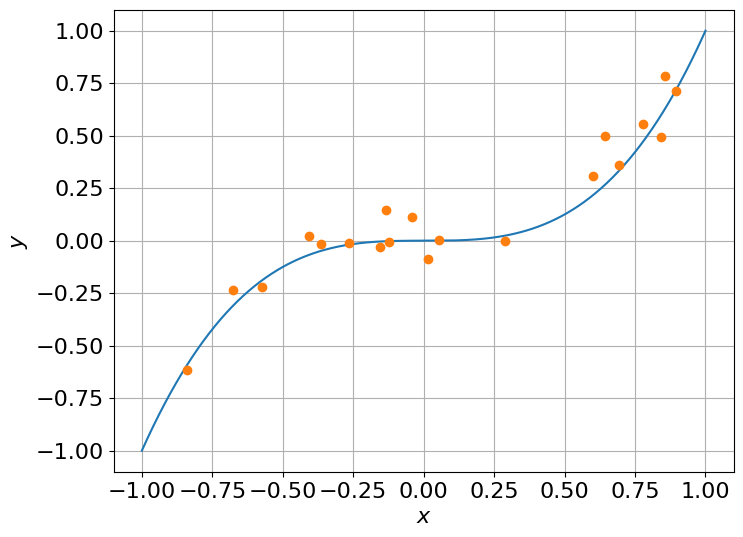

In [4]:
N_all = 1001
x_all = np.linspace(-1, 1, N_all)
y_all_noiseless = np.power(x_all, 3)
np.random.seed(42)
y_all = y_all_noiseless + np.random.normal(loc=0.0, scale=0.1, size=x_all.shape)

N = 20

subset = np.random.choice(N_all, size=N, replace=False)
X = x_all[subset]
y = y_all[subset]


plt.plot(x_all, y_all_noiseless)
plt.plot(X, y, 'o')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()

# Definition of the Linear Regression with regularization

In [5]:
class LinearRegression:
    def __init__(self, d, lam):
        self.d = d
        self.lam = lam

    # create the polynomial feature vector
    def _Phi(self, X):
        Z = np.ones((len(X), self.d + 1))
        for i in range(self.d + 1):
            Z[:, i] = np.power(X, i)
        return Z
    
    def fit(self, X, y):
        Z = self._Phi(X)
        w = (np.linalg.inv(Z.T @ Z + self.lam * np.eye(self.d + 1)) @ Z.T) @ y[:, None]
        self.w = w
        
    def h(self, X):
        return (self._Phi(X) @ self.w)[:, 0]
    
    def E(self, X, y):
        return np.mean(np.power(y - self.h(X), 2))

## Study unregularized solution

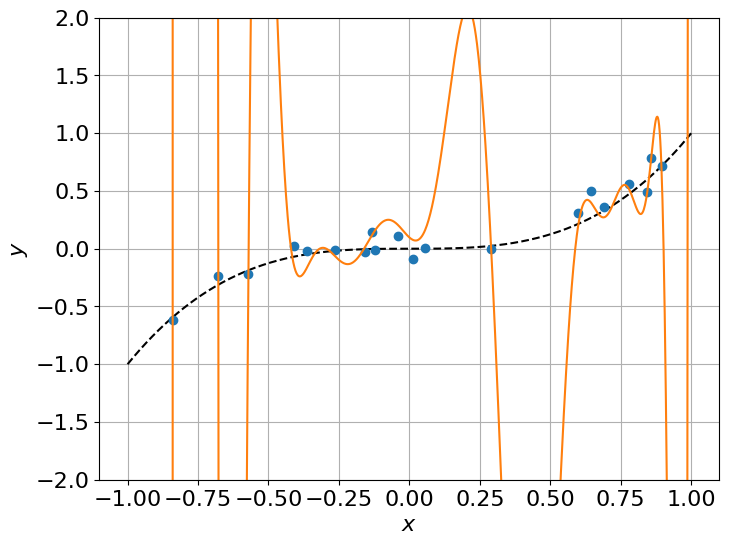

In [6]:
d = N - 1
lam = 0

lr = LinearRegression(d, lam)
lr.fit(X, y)

plt.plot(x_all, y_all_noiseless, 'k--')
plt.plot(X, y, 'o')
plt.plot(x_all, lr.h(x_all), '-')
plt.ylim([-2, 2])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()

## Repeat for multiple $\lambda$

In [7]:
lam = np.zeros(9)
lam[1:-2] = 1.0 / np.power(10, np.arange(5, -1, -1))
lam[-2] = 10
lam[-1] = 100

print(lam)

[0.e+00 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02]


19
19
19
19
19
19
19
19
19


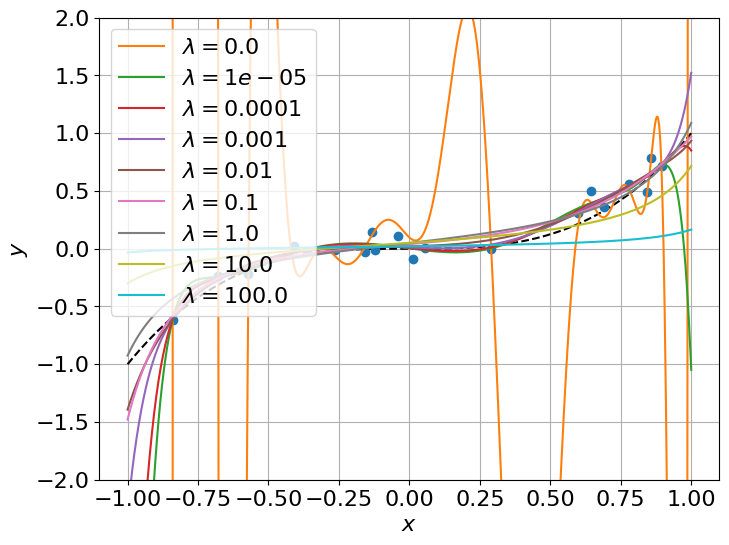

In [8]:
plt.plot(x_all, y_all_noiseless, 'k--')
plt.plot(X, y, 'o')

E_in = np.zeros(len(lam))
E_out = np.zeros(len(lam))

for i, l in enumerate(lam):
    print(d)
    lr = LinearRegression(d, l)
    lr.fit(X, y)
    # in sample error
    E_in[i] = lr.E(X, y)
    # out of sample error
    E_out[i] = lr.E(x_all, y_all)
    plt.plot(x_all, lr.h(x_all), '-', label='$\lambda = ' + str(l) + '$')
    
plt.ylim([-2, 2])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.legend()

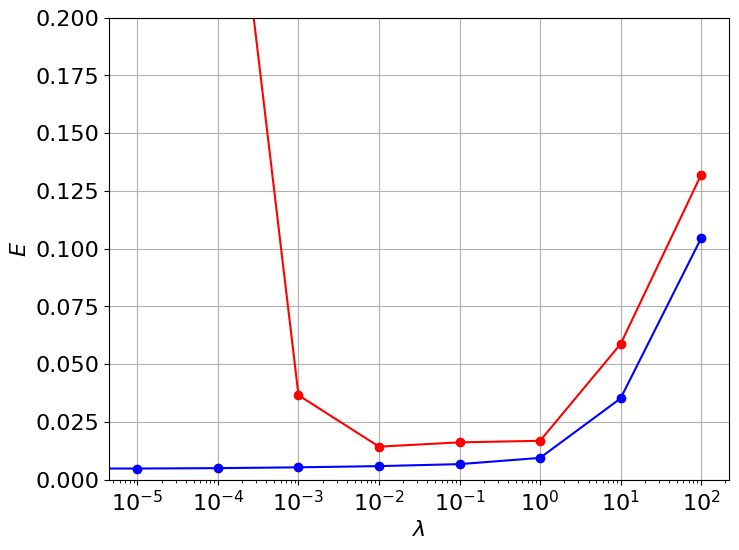

In [9]:
fig = plt.figure()
ax = plt.axes()
ax.set_xscale('log') 
ax.set_ylim([0, .2])
ax.plot(lam, E_in, 'bo-')
ax.plot(lam, E_out, 'ro-')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('$E$')
ax.grid()

# Cross validation

In [10]:
def CV(X, y, d, lam, K=10):
    E_CV = 0
    N = X.shape[0]
    permutation =  np.random.permutation(N)
    X_perm = X[permutation]
    y_perm = y[permutation]

    slice_size = N // K
    for k in range(K):
        i_lower = k * slice_size
        i_upper = k * slice_size + slice_size
        mask = np.arange(i_lower, i_upper)
        X_train = np.delete(X_perm, mask)
        X_val = X_perm[mask]

        y_train = np.delete(y_perm, mask)
        y_val = y_perm[mask]

        lr = LinearRegression(d, lam)
        lr.fit(X_train, y_train)
        error = lr.E(X_val, y_val)
        E_CV += error
    E_CV /= K

    return E_CV

In [11]:
E_CV = np.zeros(len(lam))
for i in range(len(lam)):
    E_CV[i] = CV(X, y, 50, lam[i],10)
    print('E_CV(lambda = ' + str(lam[i]) + ') = ' + str(E_CV[i]))

i_min = np.argmin(E_CV)
lam_min = lam[i_min]

print('Best lambda = ' + str(lam_min))

E_CV(lambda = 0.0) = 110211347522.59859
E_CV(lambda = 1e-05) = 0.4891193398869815
E_CV(lambda = 0.0001) = 0.09544007334192994
E_CV(lambda = 0.001) = 0.028423861875540503
E_CV(lambda = 0.01) = 0.011798046743094101
E_CV(lambda = 0.1) = 0.012774947419559559
E_CV(lambda = 1.0) = 0.01840110084126655
E_CV(lambda = 10.0) = 0.047430184440538106
E_CV(lambda = 100.0) = 0.11280501589264728
Best lambda = 0.01


In [12]:
lr0 = LinearRegression(d, 0)
lr0.fit(X, y)

lr_best = LinearRegression(50, 0.01)
lr_best.fit(X, y)

# print(lr0.w)
print(lr_best.w)

[[ 2.07413420e-02]
 [ 5.67622590e-02]
 [ 2.08296116e-01]
 [ 8.96205051e-01]
 [-8.99226151e-02]
 [ 1.52953457e-01]
 [-1.69979712e-01]
 [-5.39725582e-02]
 [-1.39856457e-01]
 [-5.60133853e-02]
 [-8.57882744e-02]
 [-1.62536085e-02]
 [-3.93430410e-02]
 [ 1.66594070e-02]
 [-7.64808325e-03]
 [ 3.48589529e-02]
 [ 1.08025252e-02]
 [ 4.14470827e-02]
 [ 1.96770827e-02]
 [ 4.09110568e-02]
 [ 2.24394257e-02]
 [ 3.67119086e-02]
 [ 2.16995148e-02]
 [ 3.10631005e-02]
 [ 1.92116965e-02]
 [ 2.52307264e-02]
 [ 1.60629581e-02]
 [ 1.98624663e-02]
 [ 1.28757077e-02]
 [ 1.52340899e-02]
 [ 9.97110094e-03]
 [ 1.14120212e-02]
 [ 7.48582472e-03]
 [ 8.35381742e-03]
 [ 5.45016864e-03]
 [ 5.96753739e-03]
 [ 3.83779423e-03]
 [ 4.14530577e-03]
 [ 2.59615446e-03]
 [ 2.78120201e-03]
 [ 1.66424069e-03]
 [ 1.77988414e-03]
 [ 9.82302274e-04]
 [ 1.05990507e-03]
 [ 4.96641240e-04]
 [ 5.54122676e-04]
 [ 1.61495251e-04]
 [ 2.08635410e-04]
 [-6.07161650e-05]
 [-1.89225805e-05]
 [-1.99994461e-04]]


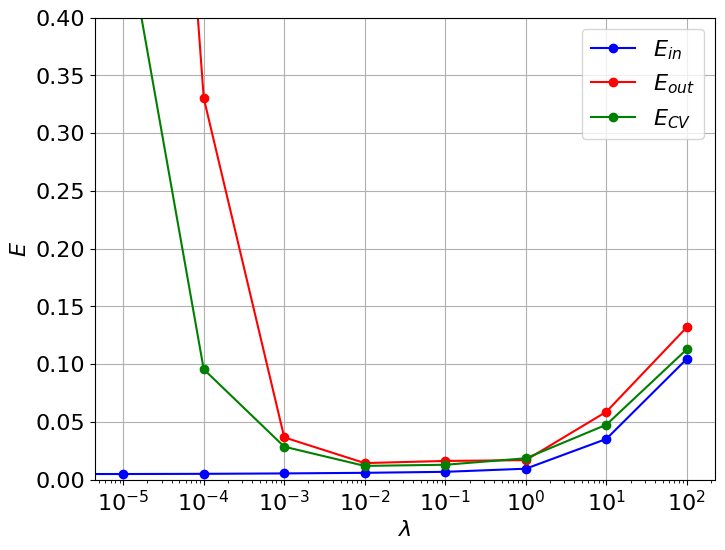

In [13]:
fig = plt.figure()
ax = plt.axes()
ax.set_xscale('log') 
#ax.set_yscale('log') 
ax.set_ylim([0, .4])
ax.plot(lam, E_in, 'bo-', label='$E_{in}$')
ax.plot(lam, E_out, 'ro-', label='$E_{out}$')
ax.plot(lam, E_CV, 'go-', label='$E_{CV}$')
ax.set_xlabel('$\lambda$')
ax.set_ylabel('$E$')
ax.grid()
ax.legend()

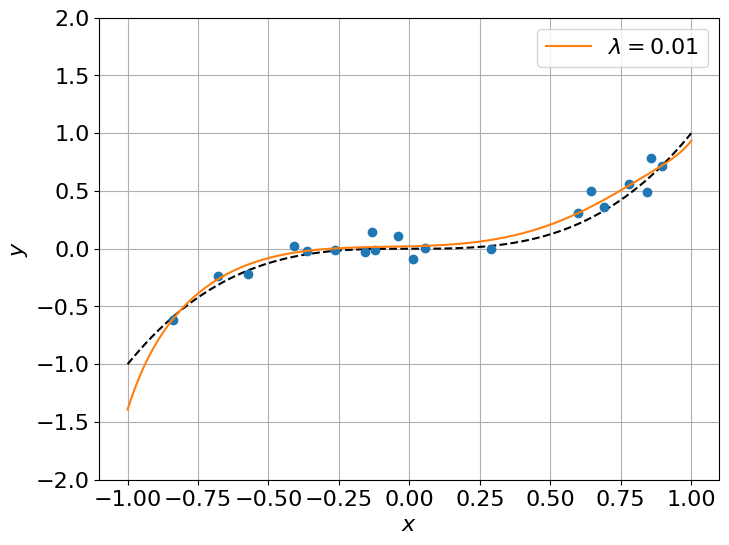

In [14]:
plt.plot(x_all, y_all_noiseless, 'k--')
plt.plot(X, y, 'o')

lr = LinearRegression(d, lam[i_min])
lr.fit(X, y)

plt.plot(x_all, lr.h(x_all), '-', label='$\lambda = ' + str(lam[i_min]) + '$')
    
plt.ylim([-2, 2])
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.grid()
plt.legend()